## Lesson 3: Collaborative-based recommender systems: Factorization

https://www.kaggle.com/prashant111/recommender-systems-in-python

https://towardsdatascience.com/recsys-series-part-4-the-7-variants-of-matrix-factorization-for-collaborative-filtering-368754e4fab5

https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

In [1]:
def evaluate(predict_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))


## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [2]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../data/ml-1m/users.dat', sep='::', names=u_cols, engine='python')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('../data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1', engine='python')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("Full DB has "+ str(data.shape[0]) +" ratings")
print("Full DB has ", data.user_id.nunique()," users")
print("Full DB has ", data.movie_id.nunique(), " movies")
data.head()


## DIVIDE THE DATA INTO TRAINING AND TEST SET
data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]


print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")

Autosaving every 150 seconds
Full DB has 1000209 ratings
Full DB has  6040  users
Full DB has  3706  movies
Training data_set has 797758 ratings
Test data set has 202451 ratings


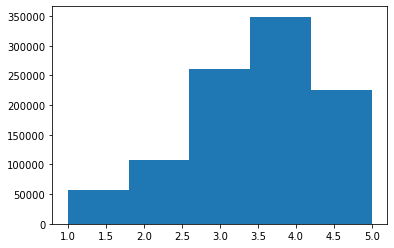

In [3]:
plt.hist(data.rating,bins=5)
plt.show()

In [4]:
data.groupby(by='rating').count()

,user_id,title,movie_id,release_date,sex,age,for_testing
rating,,,,,,,
1,56174,56174,56174,56174,56174,56174,56174
2,107557,107557,107557,107557,107557,107557,107557
3,261197,261197,261197,261197,261197,261197,261197
4,348971,348971,348971,348971,348971,348971,348971
5,226310,226310,226310,226310,226310,226310,226310


## MATRIX FACTORIZATION 

Matrix factorization algorithms work by decomposing the user-item interaction matrix (R) into the product of two lower dimensionality rectangular matrices.

![alt factorization models](https://miro.medium.com/max/988/1*nIVWl2ROaxOY23hHajkTTg.png)

These methods became really popular due to the shown efficiency in the Netflix Prize Challenge. 

There are several variants of these methods:
* SVD 
* Vanilla Factorization Matrix (also knwon as Funk SVD)
* Vanilla Factorization Matrix with biases 

### SVD Decomposition

Singular Value Decomposition (SVD) is a well established technique for identifying latent semantic factors. Done by factorizing the user-item rating matrix.

The singular value decomposition is a methods that decomposes a matrix into three other matrices as given below:
$$ R = USV^T$$

Where
* $R$ is a $m\times n$ rating matrix;
* $U$ is a $m\times k$ orthogonal left singular matrix, which represents the relationship between users and latent factors and it is known user latent matrix;
* $S$ is a $r\times r$ diagonal matrix, whcih describes the strengh of each latent factor, and;
* $V$ is a $n \times k$ orthogonal right singular matrix, which represents the relationship between items and latent factors and it is known item latent matrix.



Columns of U and V are constrained to be mutually orthogonal. 

Mutual orthogonality has the advantage that the concepts can be completely independent of one another. Can be interpre
ted in scatterplots

**Problem**: $R$ matrix needs to be complete in order to be decomposed
* Solution: fill missing values with the mean rating of the user

In [62]:
from scipy import sparse
from scipy.linalg import sqrtm

class RecSys_mf():
    """ Collaborative filtering using SVD. """
    
    def __init__(self,df, num_components=10):
        """ Constructor """
        self.num_components=num_components
        self.train = pd.pivot_table(df[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        user_index = np.arange(len(self.train.index))
        self.users = dict(zip(user_index,self.train.index ))
        self.users_id2index = dict(zip(self.train.index,user_index)) 
        
        movie_index = np.arange(len(self.train.columns))
        self.movies = dict(zip(movie_index,self.train.columns )) 
        self.movies_id2index= dict(zip(self.train.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.train.columns))
        self.movie_id2title = dict(df.groupby(by=['movie_id','title']).count().index)
        
        
    def fit(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        train_matrix = np.array(self.train)
        # we mask those nan value to fill with the mean 
        mask = np.isnan(train_matrix)
        masked_arr = np.ma.masked_array(train_matrix, mask)
        item_means = np.mean(masked_arr, axis=0)

        # nan entries will replaced by the average rating for each item
        train_matrix = masked_arr.filled(item_means)
        x = np.tile(item_means, (train_matrix.shape[0],1))         

        # we remove the per item average from all entries.
        # the above mentioned nan entries will be essentially zero now
        train_matrix = train_matrix - x
        U, s, V = np.linalg.svd(train_matrix, full_matrices=False)

        # reconstruct rating matix
        S = np.diag(s[0:self.num_components])
        U = U[:,0:self.num_components]
        V = V[0:self.num_components,:]
        S_root = sqrtm(S)

        USk=np.dot(U,S_root)
        SkV=np.dot(S_root,V)
        Y_hat = np.dot(USk, SkV)
        self.Y_hat = Y_hat + x
        
    def predict(self, user_id, movie_id):
        if movie_id in self.movies_id2index:
            return self.Y_hat[self.users_id2index[user_id],self.movies_id2index[movie_id]]
        else: # in case it is a new movie 
            return 3

In [63]:
reco = RecSys_mf(data_train,num_components=30)
reco.fit()
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

RMSE for Collaborative Recomender: 0.9983861143351299


### The Vanilla Matrix Factorization Model 
* Also know as **Funk SVD**
* * Despite its name, in Funk SVD, no singular value decomposition is applied.
* * https://sifter.org/simon/journal/20061211.html

A straightforward matrix factorization model maps both users and items to a joint latent factor space of dimensionality D. User-item interaction are modeled as inner products in that space
$$R = UV$$

Each item j is associated with a vector $v_j$ from $V$, and each user $i$ is associated with a vecor $u_i$ from $U$.
The resulting dot product $u_i\cdot v_j$ captures the interaction between the user $i$ and item $j$:
$$ \hat{r} = u_i\cdot v_j$$

The goal of the matrix factorization consist on finding the mapping of each item and user to factors $u_i$ and $v_j$. To do so, the minimization the of squarred error function is performed:
$$ \sum(R_{ui} - u_i\cdot v_j)^2$$

This factorization can be learnt using **only those known ratings**. We do not need to infer missing values.

![alt Amazon](https://miro.medium.com/max/4800/1*b4M7o7W8bfRRxdMxtFoVBQ.png)

In [7]:
from scipy import sparse

class RecSys_vanilla_mf(RecSys_mf):
    """ Collaborative filtering using a custom sim(u,u'). """

    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - \
                                     self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - \
                                     self.lmbda * self.item_vecs[i,:])
                
                
    def fit(self,n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ Train the model. """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.ratings = np.float32(self.train.fillna(0).values)
        self.n_users, self.n_items = self.train.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = 3.*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = 3.*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))

        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(self.predict,data_train,data_train))
            self.test_rmse.append(evaluate(self.predict,data_train,data_test))
            
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T)
        else:
            prediction = 3 # this is a new movie
        if(prediction>5): # clip the result
            return 5
        elif(prediction<1):
            return 1
        return prediction
    

Epoch: 0
	Train rmse: 1.3221481738228462
	Test rmse: 1.337599864679777
Epoch: 1
	Train rmse: 1.131880745892883
	Test rmse: 1.144533739207827
Epoch: 2
	Train rmse: 1.1036373177910865
	Test rmse: 1.1133999958929706
Epoch: 3
	Train rmse: 1.0934572008248704
	Test rmse: 1.102597568533063
Epoch: 4
	Train rmse: 1.0915768273739634
	Test rmse: 1.0999030907807639


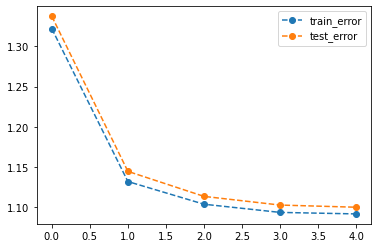

RMSE for Collaborative Recomender: 1.0999030907807639


In [8]:
reco = RecSys_vanilla_mf(data_train,num_components=5)
reco.fit(n_epochs = 5,learning_rate=0.01,lmbda=0.5)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

Epoch: 0
	Train rmse: 1.1666797019867565
	Test rmse: 1.1874929479832705
Epoch: 1
	Train rmse: 1.0272461055864301
	Test rmse: 1.0442403425117173
Epoch: 2
	Train rmse: 1.0041219963362216
	Test rmse: 1.0188213012018217
Epoch: 3
	Train rmse: 0.9963078965194427
	Test rmse: 1.0104332076272013
Epoch: 4
	Train rmse: 0.991265406518838
	Test rmse: 1.0050457911896855


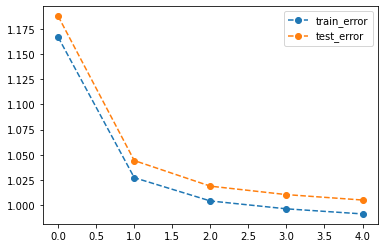

RMSE for Collaborative Recomender: 1.0050457911896855


In [9]:
reco = RecSys_vanilla_mf(data_train,num_components=5)
reco.fit(n_epochs = 5,learning_rate=0.01)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

Epoch: 0
	Train rmse: 1.0387646660724312
	Test rmse: 1.0550995281762026
Epoch: 1
	Train rmse: 1.0066212106789665
	Test rmse: 1.0208947112328406
Epoch: 2
	Train rmse: 1.0001070389026212
	Test rmse: 1.0138785826820769
Epoch: 3
	Train rmse: 0.9908258002088102
	Test rmse: 1.0057587469916756
Epoch: 4
	Train rmse: 0.986347920516114
	Test rmse: 1.0017024559120862
Epoch: 5
	Train rmse: 0.9820084481229016
	Test rmse: 0.9976327893820701
Epoch: 6
	Train rmse: 0.977015513941032
	Test rmse: 0.9925306496338409
Epoch: 7
	Train rmse: 0.9744856749931141
	Test rmse: 0.9917427377230865
Epoch: 8
	Train rmse: 0.9733873892383832
	Test rmse: 0.9906033031239377
Epoch: 9
	Train rmse: 0.9709115672855023
	Test rmse: 0.9884040167246635
Epoch: 10
	Train rmse: 0.9702473778020458
	Test rmse: 0.9888471705645735
Epoch: 11
	Train rmse: 0.9701760550836835
	Test rmse: 0.9882594968955473
Epoch: 12
	Train rmse: 0.9671061945003752
	Test rmse: 0.9870158326172159
Epoch: 13
	Train rmse: 0.9656706875347185
	Test rmse: 0.9844631

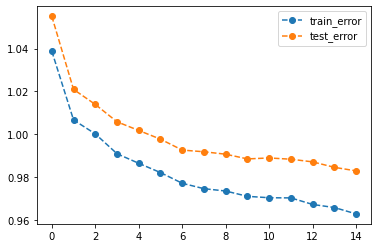

RMSE for Collaborative Recomender: 0.9828043654024506


In [10]:
reco = RecSys_vanilla_mf(data_train,num_components=5)
reco.fit(n_epochs = 15,learning_rate=0.02)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

In [11]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

[('Lion King, The (1994)', 354),
 ('Rudy (1993)', 510),
 ('Mr. Mom (1983)', 3325),
 ('Karate Kid, The (1984)', 2206),
 ('Crimson Tide (1995)', 155),
 ('American President, The (1995)', 10)]

### The Vanilla Matrix Factorization Model with biases 

* Despite its name, in SVD++, no singular value decomposition is applied.


Now the model is defined as:
$\hat{r}_{ui} = \bar{r} + b_{u_u} + b_{i_i}  \sum_{k = 1}^KP_{uk} Q_{ik}^T  $

To learn the model we can use the SGD as before. Now the latent factors and biases are updated as follows:
* $error = r -\hat{r}$
* $b_{u_u} = b_{u_u} + \alpha*(error -  \lambda*b_{u_u})$
* $b_{i_i} = b_{i_i} + \alpha*(error -  \lambda*b_{i_i})$
* $P_{uk} = P_{uk} + \alpha*(error*Q_{ik} -  \lambda*P_{uk})$
* $Q_{ik} = Q_{ik} + \alpha*(error*P_{uk} -  \lambda*Q_{ik})$

where $\alpha$ is the learning rate and $\lambda$ is the regularization term.

In [53]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

class RecSys_vanilla_mf_biases(RecSys_vanilla_mf):
                  
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
            
                
    def fit(self,n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ Train the model. """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.ratings = np.float32(self.train.fillna(0).values)
        self.mean_rating = self.ratings[self.ratings>0].mean() 
        self.n_users, self.n_items = self.train.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        #self.bias = -3
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        
        
        for epoch in range(n_epochs):
    
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(reco.predict,data_train,data_train))
            self.test_rmse.append(evaluate(reco.predict,data_train,data_test))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def predict(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.mean_rating + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = self.mean_rating # this is a new movie

        return prediction
    

Epoch: 0
	Train rmse: 0.9913468457368302
	Test rmse: 0.9979949215042784
Epoch: 1
	Train rmse: 0.9870806122745771
	Test rmse: 0.9948522793356623
Epoch: 2
	Train rmse: 0.984805044184194
	Test rmse: 0.9930639953514394
Epoch: 3
	Train rmse: 0.9811079100864476
	Test rmse: 0.9901354370234936
Epoch: 4
	Train rmse: 0.9762339479771873
	Test rmse: 0.9860990867528389


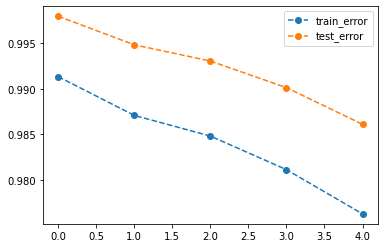

RMSE for Collaborative Recomender: 0.9860990867528389


In [54]:
reco = RecSys_vanilla_mf_biases(data_train,num_components=5)
reco.fit(n_epochs = 5,learning_rate=0.02)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict,data_train,data_test))

In [59]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
#movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

[('Toy Story (1995)', 0),
 ('Toy Story 2 (1999)', 2877),
 ('Aladdin (1992)', 574),
 ("Bug's Life, A (1998)", 2141),
 ('Babe (1995)', 33),
 ('Big Combo, The (1955)', 3041)]

Epoch: 0
	Train rmse: 0.9918404400582648
	Test rmse: 0.9971472031926873
Epoch: 1
	Train rmse: 0.9883250250796387
	Test rmse: 0.9947714430050477
Epoch: 2
	Train rmse: 0.9873538383282028
	Test rmse: 0.9939117222403017
Epoch: 3
	Train rmse: 0.9865226764681743
	Test rmse: 0.9931890463365158
Epoch: 4
	Train rmse: 0.9847341921207973
	Test rmse: 0.9921212028814881
Epoch: 5
	Train rmse: 0.980232185010492
	Test rmse: 0.9885202367159757
Epoch: 6
	Train rmse: 0.9746726681683542
	Test rmse: 0.9841406770355249
Epoch: 7
	Train rmse: 0.9710660827443498
	Test rmse: 0.9810255847808734
Epoch: 8
	Train rmse: 0.968707488046929
	Test rmse: 0.9795449514946007
Epoch: 9
	Train rmse: 0.9664471557412316
	Test rmse: 0.9778740088787097
Epoch: 10
	Train rmse: 0.9633652309288895
	Test rmse: 0.9757426072061828
Epoch: 11
	Train rmse: 0.9606101761812883
	Test rmse: 0.9738740740273314
Epoch: 12
	Train rmse: 0.9577916641541371
	Test rmse: 0.9720319350355445
Epoch: 13
	Train rmse: 0.9547078264025206
	Test rmse: 0.9700805

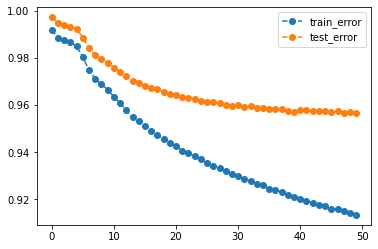

In [58]:
reco = RecSys_vanilla_mf_biases(data_train,num_components=100)
reco.fit(n_epochs = 50,learning_rate=0.02,lmbda=0.1)

In [61]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
#movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

[('Toy Story (1995)', 0),
 ('Toy Story 2 (1999)', 2877),
 ('Aladdin (1992)', 574),
 ("Bug's Life, A (1998)", 2141),
 ('Babe (1995)', 33),
 ('Big Combo, The (1955)', 3041)]

### Funk SVD
Funk SVD is the original algorithm proposed by Simon Funk. It become really popular because of the Netfliz Prize.



We have a huge sparse matrix $R$ of user-item interactions;


$R = \begin{pmatrix} {\color{Red} ?} & 2 & \cdots & {\color{Red} ?} & {\color{Red} ?} \\ {\color{Red} ?} & {\color{Red} ?} & \cdots & {\color{Red} ?} & 4.5 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 3 & {\color{Red} ?} & \cdots & {\color{Red} ?} & {\color{Red} ?} \\ {\color{Red} ?} & {\color{Red} ?} & \cdots & 5 & {\color{Red} ?} \end{pmatrix}$

The idea is to estimate the unknown rating by factorizing the matrix into two smaller matrices representing the user and the item characteristics. These matrices are callent user, $P$, and item, $Q$, latent factors. Then the dot product between these two matrices reconstruct our rating matrix:
$$ R \approx P*Q^T$$


Despite its name, in Funk SVD, no singular value decomposition is applied.


In order to estimate these matrices $P$ and $Q$ we can use 


### Factorization Matrix as Dimensionality Reduction